In [432]:
import pandas as pd
import numpy as np
import requests
import os
import glob
import shutil
import string
import random
import pygad

from sklearn.preprocessing import MultiLabelBinarizer

In [433]:
def calc_target(kpis):
    return sum(5*(x_ref - x_ours) if x_ref > x_ours else x_ref - x_ours for x_ref, x_ours in kpis)

In [434]:
KPIS_WEIGHTS = [1, -1, -1]

### Helper functions

In [435]:
# Maximized (1)
def get_amount(solution):
    solution2 = solution.loc[~(solution.drop(columns="amount") == 0).all(axis=1)]
    return solution2["amount"].mean()


def divide_amount_between_validators(solution):
    amounts = solution["amount"]
    solution_amountless = solution.drop(columns="amount")

    mask = solution_amountless == 1
    nominators_selected_validators_counts = mask.sum(axis=1)
    safe_selected_counts = nominators_selected_validators_counts.replace(0, 1)

    distributed_amounts = (amounts / safe_selected_counts).values[:, None] * mask

    validators_to_money = distributed_amounts.sum(axis=0)

    validators_to_money_dict = dict(zip(solution_amountless.columns, validators_to_money))

    return validators_to_money_dict


# Minimized (-1)
def get_standard_deviation(solution):
    return np.array(list(divide_amount_between_validators(solution).values())).std()


# Minimized (-1)
def get_assignment(solution):
    nominatorsAssignments = (solution.iloc[:, :-1] == 1).sum(axis=1)
    return ((nominatorsAssignments - 1) ** 2).sum()


def create_kpis(solution):
    solution_amount = get_amount(solution) * KPIS_WEIGHTS[0]
    solution_variance = get_standard_deviation(solution) * KPIS_WEIGHTS[1]
    solution_assignment = get_assignment(solution) * KPIS_WEIGHTS[2]

    return [solution_amount, solution_variance, solution_assignment]


def concatenate_solutions(sol1, sol2):
    result = []
    for s1, s2 in zip(sol1, sol2):
        result.append((s1, s2))

    return result


def compare_solutions(sol1, sol2):
    return calc_target(concatenate_solutions(create_kpis(sol1), create_kpis(sol2)))


def get_data_batches(nominators_filepath_pattern='data/polkadot_nominators_session_*.csv', batch_size=1, default_min=0):
    file_paths = glob.glob(nominators_filepath_pattern)
    num_batches = len(file_paths) // batch_size + (1 if len(file_paths) % batch_size != 0 else 0)
    data_batches = []
    for i in range(num_batches):
        nominators_batches = [pd.read_csv(file) for file in file_paths[i * batch_size: (i + 1) * batch_size]]
        all_data = pd.concat(nominators_batches, ignore_index=True)
        min_batch_amount = default_min if default_min == 0 else all_data["bonded_amount"].min()
        max_batch_amount = all_data["bonded_amount"].max()

        nominators_batches = list(map(lambda x: remove_empty_targets_row(x, min_batch_amount, max_batch_amount), nominators_batches))
        data_batches.append(nominators_batches)
    return data_batches


def remove_empty_targets_row(nominators_df, min_amount, max_amount):
    nominators_no_na = nominators_df[nominators_df["targets"].notna()]
    return normalize_amount_column(nominators_no_na, min_amount, max_amount)


def normalize_amount_column(nominators_df, min_amount, max_amount):
    nominators_df['bonded_amount'] = (nominators_df['bonded_amount'] - min_amount) / (max_amount - min_amount)
    return nominators_df


def flatten_solution(solution):
    indices = solution.index.to_numpy()
    data_matrix = solution.to_numpy()
    return np.concatenate(np.hstack([
        indices[:, None],
        data_matrix
    ]))


def create_binary_matrix(nominators):
    mlb = MultiLabelBinarizer()
    binary_matrix = mlb.fit_transform(nominators["targets"].str.split(','))
    binary_matrix = pd.DataFrame(binary_matrix, columns=mlb.classes_, index=nominators["stash_address"])
    binary_matrix["amount"] = nominators.set_index("stash_address")["bonded_amount"]
    return binary_matrix


def create_random_solution(nominators, number_of_validators):
    binary_matrix = create_binary_matrix(nominators)
    binary_matrix_dropped = binary_matrix.drop(columns="amount")
    random_solution = binary_matrix_dropped.sample(n=number_of_validators, axis=1)
    random_solution['amount'] = nominators.set_index('stash_address')['bonded_amount']
    return random_solution

In [436]:
google_cloud_url = "https://storage.googleapis.com/watcher-csv-exporter/"
session_filename_template = string.Template("polkadot_nominators_session_$id.csv")
era_filename_template = string.Template("polkadot_validators_era_$id.csv")

Loading of data starting from era number 165 and session 1031

In [437]:
def download_file(url, destination):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(destination, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

def download_batch(starting_era=1000, starting_session=6041, destinationFolder="data/", number_of_eras_to_download=1):
    if os.path.exists(destinationFolder):
         shutil.rmtree(destinationFolder)
         
    os.makedirs(destinationFolder, exist_ok=True)
    era_id = starting_era
    session_id = starting_session
    total_eras_downloaded = 0

    while total_eras_downloaded < number_of_eras_to_download:
        era_filename = era_filename_template.substitute({'id': era_id})

        try:
            download_file(
                google_cloud_url + era_filename,
                destinationFolder + era_filename
            )
        except Exception as e:
            era_id += 1
            session_id += 6
            continue
        
        session_filename = session_filename_template.substitute({'id': session_id})
        download_file(
            google_cloud_url + session_filename,
            destinationFolder + session_filename
        )

        total_eras_downloaded += 1
        era_id += 1
        session_id += 6

### Download of data

In [438]:
STARTING_ERA = 165
STARTING_SESSION = 1031
download_batch(starting_era=STARTING_ERA, starting_session=STARTING_SESSION)

In [439]:
nominators = get_data_batches()[0][0]
validators = pd.read_csv(f"data/polkadot_validators_era_{STARTING_ERA}.csv")

In [440]:
nominators

,era,session,block_number,stash_address,controller_address,bonded_amount,num_targets,targets
0,165,1031,2465718,16Ak2D2ZApaR6sFKkawmC8ea93ASD4aB54eTMvEkDjCFZLjp,16Ak2D2ZApaR6sFKkawmC8ea93ASD4aB54eTMvEkDjCFZLjp,6.625483e-05,1,1hJdgnAPSjfuHZFHzcorPnFvekSHihK9jdNPWHXgeuL7zaJ
1,165,1031,2465718,14FzsWSxgWMmXwafTiGf1YdXZgEoAY7dEv2Qr9h1sCHaWFt2,14FzsWSxgWMmXwafTiGf1YdXZgEoAY7dEv2Qr9h1sCHaWFt2,1.819291e-06,16,1zugcacYFxX3HveFpJVUShjfb3KyaomfVqMTFoxYuUWCdD...
2,165,1031,2465718,15LL8mQJQ7wsxrjxMyBxjphkNxciwirC6cQ5AprmmEt8KGNf,15wtWHaQemsJL4uPKGKCRwnpaGUK66VdLjd8wJKWcpoEtetf,6.075376e-05,16,1zugcabYjgfQdMLC3cAzQ8tJZMo45tMnGpivpAzpxB4CZy...
3,165,1031,2465718,11888uchjZxbyc7RRstxZ8qepsskRjJhJatrxryBTdHuWfK,11888uchjZxbyc7RRstxZ8qepsskRjJhJatrxryBTdHuWfK,3.945346e-03,5,14cxMDpBNLsNEXWyCzked3zghzaYWXwoqGT4h12GqQXdVh...
4,165,1031,2465718,1ZQpD1knimbf4RLUyoipThPdhvEXJHud2sFDSe3cWPVN3q4,1ZQpD1knimbf4RLUyoipThPdhvEXJHud2sFDSe3cWPVN3q4,6.532219e-06,16,14SRtmkZPGzaV1bKivd7T6xw15YRW53gjE5F2LVbiwChqK...
...,...,...,...,...,...,...,...,...
8198,165,1031,2465718,16XMi2A7NvUuwt632GH7awa7P5MYJQrteJJ3iB13FCqeXPok,16XMi2A7NvUuwt632GH7awa7P5MYJQrteJJ3iB13FCqeXPok,4.663159e-06,10,15awXd39ZEttFj5tyM6Lkq5ReefCNcrG8f2agSgn2ZCjoJ...
8199,165,1031,2465718,16A5SmtCw1sTDr6zXdJ9hShqUX1XbYKXG1kk8Qv2BPhTsDNC,16A5SmtCw1sTDr6zXdJ9hShqUX1XbYKXG1kk8Qv2BPhTsDNC,4.122758e-07,16,12vCVEpCz81rvS23PEJQ6KBDbPWgvyVX5Q1PrgQbVvLc4i...
8200,165,1031,2465718,14N6uWVnUDZQfNf66HJsSFPLmJHm1p19Y44CBmVoBi9DDbRD,14N6uWVnUDZQfNf66HJsSFPLmJHm1p19Y44CBmVoBi9DDbRD,2.437195e-11,4,12LKeuFyyjC94iXpHftt3UVu567ji5WyKE6MvDBDWVJUuu...
8201,165,1031,2465718,13gfodUESWspVuk5xHdkC8uCJi3EAvTtjiaRCUsN9ktwhpKR,13gfodUESWspVuk5xHdkC8uCJi3EAvTtjiaRCUsN9ktwhpKR,2.012874e-04,5,15DLJZ4ceN58vEgDiQjK8JsSJuLNBqhUnQ6QCY1QNSjrQn...


In [441]:
number_of_validators = len(validators)
validators

,era,session,block_number,name,stash_address,controller_address,commission_percent,self_stake,total_stake,num_stakers,voters,era_points
0,165,1031,2465718,Wei,14ShUZUYUR35RBZW6uVVt1zXDxmSQddkeDdXf1JkMA6P721N,16knCdWHWokjeciJuassAub21PHi3YTt94um4DjRJSRtF7sh,1.0,2331305558010386,30622799978313560,127,1831,1260
1,165,1031,2465718,NaN,1FCu68ZwBHNzZLcGa92eHwvR61hk3MpjrhiqN96xF9vWS1Q,13gAjcC56upxCdaNS69jB7rvGDzimcztTm9Jxhfgma8w9jor,100.0,99360406100,37263464975913580,2,27,1300
2,165,1031,2465718,Zug Cap / 19,1zugcag7cJVBtVRnFxv5Qftn7xKAnR6YJ9x4x3XLgGgmNnS,13eeBGJPSPQjXGfBmd2rsek8gKU1ivz7eZReiVRwwES1QzuX,0.7,100000000000,30549484370550930,106,1203,1260
3,165,1031,2465718,Polkadot.pro - Realgar,1REAJ1k691g5Eqqg9gL7vvZCBG7FCCZ8zgQkZWd4va5ESih,1ZMbuCR3QiatxRsQdNnJYgydn3CWV4PELcTzpH4TNoNjxno,1.0,5342981819844241,34321621635570840,128,1329,1120
4,165,1031,2465718,Able Wanderer / 🐁 Mouse-6,135wKSGZpQcTrhmFju9VeKC68gMBMsCYpSNtDyoqj3BVSZ1R,135wKSGZpQcTrhmFju9VeKC68gMBMsCYpSNtDyoqj3BVSZ1R,100.0,10000000000,26135922035705640,4,9,1180
...,...,...,...,...,...,...,...,...,...,...,...,...
223,165,1031,2465718,NaN,14yVcx8AtnmaZMCZWVp8AKDgnAYdjeQjAbPL1HbvPxr74Fsf,16H1vG9t6EzS64r4YgLHBEXwKkVG23gE8t84DzXTtUi1ucxv,100.0,99360406100,24840579921059186,1,1,1200
224,165,1031,2465718,P2P.ORG / 18,16Sud9b5uUfUi1HXdfwb3drbYBZBLPVvdKuZhwxz2n7HR12M,16Sud9b5uUfUi1HXdfwb3drbYBZBLPVvdKuZhwxz2n7HR12M,3.0,100000533506,30626119242918828,50,283,1280
225,165,1031,2465718,🔒stateless_money🔒,12713bbq45c66CN9AD7yusSXWE1kY91DcMpjVcB2rXqZKy2w,1f2K1YccCZEfbcGrHshQWzrGdXp6bxFgMahGrKYZm9HPuy1,1.0,2000590510261,31150322561480132,15,95,1220
226,165,1031,2465718,NaN,15rQD4ykz4uRD7YGdTpMT8UmgkNDJRKckZbAocALndBVzCjf,15rQD4ykz4uRD7YGdTpMT8UmgkNDJRKckZbAocALndBVzCjf,100.0,10000000000,24620024373998627,3,7,1020


In [442]:
target = nominators["targets"][0]
validators[validators["stash_address"] == target]

,era,session,block_number,name,stash_address,controller_address,commission_percent,self_stake,total_stake,num_stakers,voters,era_points
97,165,1031,2465718,Listen,1hJdgnAPSjfuHZFHzcorPnFvekSHihK9jdNPWHXgeuL7zaJ,136JdPA8uidFAUPJKarwpBsPqGkkRqLTYgNBC7vuwyAnLd6a,5.0,1799881215889431,30614677019378986,171,550,1580


Creation of binary table similar to one in presentation, so showing which validators nominator selected and his total money

In [443]:
binary_matrix = create_binary_matrix(nominators)
binary_matrix

,111111111111111111111111111111111HC1,1124RsfEgJEZvEq4HbtGFcpqoxnqSy79EjNZY9tzPct3AB6o,112Ji3ASaU21FGa4ymrjvyZrDv8LbW9tF5NLUksdLdJkjY7E,1155dDdp1X4F3rh35hAMoK8r4iDVdzprtRpVrScP35YPC2b,11BgR7fH8Sq6CcGcXxZrhyrBM2PUpDmhnGZpxPGvVGXEiPT,11MJU5Q1rQh5BKuuECePhSAutv3WEVx6f2x9eZk9HXkCC1e,11gqpAyU17G9EFW5n5MNngh824F3Y2as72V2rgc7Wq5JVRd,11uMPbeaEDJhUxzU4ZfWW9VQEsryP9XqFcNRfPdYda6aFWJ,121GBc2ZK53Uoc6JovJjU7zARH8fys5efyUfHKT9vABpqajx,121ZiNk5DKVKUuYQtuNcHC25AD2K8bSNaaFn7qSa4JrSwYBR,...,1zugcauBVvcNa6tpW3j6WaGRL1Wvm9oSimK2eP3VNqNLw1V,1zugcavJYzi2KErZy9CMbLANhfrFwMESgPz9q29eUCR5gTW,1zugcavYA9yCuYwiEYeMHNJm9gXznYjNfXQjZsZukF1Mpow,1zugcawsx74AgoC4wz2dMEVFVDNo7rVuTRjZMnfNp9T49po,1zugcaxRrQDr7ktb6SpjVMkywys2ysoZWBfUfs9CDPwFVHC,1zugcaxcGLmRb6wFpftx99sYRSQihqq6KLTThimEkYsaSoq,1zugcazy9vaQJkMX79DYwFdvTYGmAbjPQrYuyUNHoFnXKtA,1zugcdarkTpYvG69VFJvxCdMVovSoWPieafJgLCnWCsYCzS,1zugchKTRDgvvfeGGSf5KpVWMx17Atf956FJYaFrmxdS4T7,amount
stash_address,,,,,,,,,,,,,,,,,,,,,
16Ak2D2ZApaR6sFKkawmC8ea93ASD4aB54eTMvEkDjCFZLjp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.625483e-05
14FzsWSxgWMmXwafTiGf1YdXZgEoAY7dEv2Qr9h1sCHaWFt2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.819291e-06
15LL8mQJQ7wsxrjxMyBxjphkNxciwirC6cQ5AprmmEt8KGNf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,6.075376e-05
11888uchjZxbyc7RRstxZ8qepsskRjJhJatrxryBTdHuWfK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.945346e-03
1ZQpD1knimbf4RLUyoipThPdhvEXJHud2sFDSe3cWPVN3q4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.532219e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16XMi2A7NvUuwt632GH7awa7P5MYJQrteJJ3iB13FCqeXPok,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.663159e-06
16A5SmtCw1sTDr6zXdJ9hShqUX1XbYKXG1kk8Qv2BPhTsDNC,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.122758e-07
14N6uWVnUDZQfNf66HJsSFPLmJHm1p19Y44CBmVoBi9DDbRD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.437195e-11


In [444]:
random_solution = create_random_solution(nominators, number_of_validators)
random_solution

,153uHgQYh3DxFKNKVqRuoftD4pmmAiUvw41p1UgUstLnKLwh,13Dfa58XRdXMQwwteaDDTs3cqwPRCYKpHkVGYLXA7Apgnf9H,15ictvkBL2D3aWxyoqh8roJkRC1tdFw3SCLqjyssjuf6yiC9,126CY11joFMpakVSRra9LtNFYWuUzbtA9BcGPpaEvn7R8RkN,15DuZrrdihPLjMxX3eEYrN3DRc25nEJUFtYk7oHHs6xeh4bZ,1zugcaZGGS82R66cdvYMiQA4vML4sqbXpXgvD4pz2pUTuNh,165JpxmCRi28GwbFAjjrD74FTfGdLfHi1LUGMaYLjziDvi4r,16JcdktXy1ykqPPtQsu4jrtSg7nBfBxKShe64oLxJkeaEb5h,13asdY4e7sWdJ4hbGW9n2rkNro1mx5YKB6WBCC9gvqKmLvNH,1434u2z8caHqrVyB9n6Zu5Zm8oQQSPtiGSKi77PKHBeFdooB,...,1zugca4o1sdz8absH67YGJ9n187D8kZoHPrh8Htma66GTYx,14zkWcFyhADd2RgdGm8RMoATNNCaWiQwZXcLbSQ4ivEbwLxP,15kkg1mK1tCGgqqo3c1CghtKCQsBEAPPjYNNmmRT3r29FeRX,148HzdSuFsDrNKnAHFs81BJzZxmKgwEC6Pmpw2QJnTy3Hv3R,14SRtmkZPGzaV1bKivd7T6xw15YRW53gjE5F2LVbiwChqKGx,126psKUiNKidXPNJRkD9TYcZdruX4dymU3vsQ6g9GM4YtEis,16KuUsyfxgQovzp8QXgtJH1K5Tmok6M8hgSoHaGbyyTQtQg,13BU2AX77ncdj8pqCDBYTbGShY38be7u2s6Ht436ANdRJhZq,14ShUZUYUR35RBZW6uVVt1zXDxmSQddkeDdXf1JkMA6P721N,amount
stash_address,,,,,,,,,,,,,,,,,,,,,
16Ak2D2ZApaR6sFKkawmC8ea93ASD4aB54eTMvEkDjCFZLjp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.625483e-05
14FzsWSxgWMmXwafTiGf1YdXZgEoAY7dEv2Qr9h1sCHaWFt2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.819291e-06
15LL8mQJQ7wsxrjxMyBxjphkNxciwirC6cQ5AprmmEt8KGNf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.075376e-05
11888uchjZxbyc7RRstxZ8qepsskRjJhJatrxryBTdHuWfK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.945346e-03
1ZQpD1knimbf4RLUyoipThPdhvEXJHud2sFDSe3cWPVN3q4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6.532219e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16XMi2A7NvUuwt632GH7awa7P5MYJQrteJJ3iB13FCqeXPok,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.663159e-06
16A5SmtCw1sTDr6zXdJ9hShqUX1XbYKXG1kk8Qv2BPhTsDNC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.122758e-07
14N6uWVnUDZQfNf66HJsSFPLmJHm1p19Y44CBmVoBi9DDbRD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.437195e-11


In [445]:
random_solution_kpis = create_kpis(random_solution)
random_solution_kpis

[0.0015947651239797717, -0.05806566591349797, -122516]

In [446]:
random_solution2 = create_random_solution(nominators, number_of_validators)
random_solution_kpis2 = create_kpis(random_solution2)
random_solution_kpis2

[0.0016214586998784686, -0.06043770672357657, -65628]

In [447]:
score = compare_solutions(random_solution, random_solution2)
score

-56887.98816648952

In [448]:
score = compare_solutions(random_solution2, random_solution)
score

284439.9977614271

In [449]:
ref_sol = binary_matrix[validators["stash_address"]]
ref_sol['amount'] = nominators.set_index('stash_address')['bonded_amount']
ref_sol_kpis = create_kpis(ref_sol)
ref_sol_kpis

/tmp/ipykernel_6781/3072509050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_sol['amount'] = nominators.set_index('stash_address')['bonded_amount']


[0.0014430420125009318, -0.01597388517473245, -480699]

In [ ]:
score = compare_solutions(ref_sol, random_solution)
score

-358182.7896928194

In [451]:
score = compare_solutions(ref_sol, random_solution2)
score

-415070.77785930893

## Gready Solution

In [452]:
## Focus On total amount
def solve_total_amount(nominators, num_of_vals):
    binary_matrix = create_binary_matrix(nominators)
    selected_validators = set()

    binary_matrix.sort_values(by='amount', inplace=True, ascending=False)
    i = 0

    while len(selected_validators) < num_of_vals:
        cols = binary_matrix.columns[binary_matrix.iloc[i] == 1].tolist()
        to_add = num_of_vals - len(selected_validators)
        if len(cols) <= to_add:
            selected_validators.update(cols)
        else:
            selected_validators.update(cols[:to_add])
        i += 1

    result = binary_matrix[list(selected_validators)]
    result['amount'] = nominators.set_index('stash_address')['bonded_amount']

    return result

In [453]:
## Focus On total amount 2
def solve_total_amount_2(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)

    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    
    expanded_nominators = nominators_copy.explode('targets')
    
    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)
    selected_validators_df = validator_stakes_sorted.head(num_of_vals)
    
    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return binary_matrix[list(selected_validators_df['validator_id']) + ['amount']]

In [454]:
## Focus on amount variance
def solve_variance_only(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)
    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    expanded_nominators = nominators_copy.explode('targets')

    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)

    selected_validators = []

    for _, validator in validator_stakes_sorted.iterrows():
        stakes = [v['total_stake'] for v in selected_validators] + [validator['total_stake']]
        variance = np.var(stakes)

        if len(selected_validators) < num_of_vals or variance < np.var(stakes[:-1]):
            selected_validators.append(validator)

        if len(selected_validators) >= num_of_vals:
            break

    selected_validators_df = pd.DataFrame(selected_validators)

    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return binary_matrix[list(selected_validators_df['validator_id']) + ['amount']]

In [455]:
## Focus on assignments
def solve_assignments_only(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)
    nominators_copy['targets'] = nominators_copy['targets'].str.split(',')
    nominators_copy_sorted = nominators_copy.sort_values(by=['num_targets', 'bonded_amount'], ascending=[False, False])

    selected_validators = set()
    encountered_validators = set()

    for _, nominator in nominators_copy_sorted.iterrows():

        if np.any([target in encountered_validators for target in nominator['targets']]):
            continue
        
        if nominator['targets']:
            chosen_validator = nominator['targets'][0]
            selected_validators.add(chosen_validator)
            encountered_validators.update(nominator['targets'])

        if len(selected_validators) >= num_of_vals:
            break

    
    if len(selected_validators) < num_of_vals:
        nominators_copy_sorted = nominators_copy.sort_values(by=['num_targets', 'bonded_amount'], ascending=[True, False])
        for _, nominator in nominators_copy_sorted.iterrows():
            available_targets = [validator for validator in nominator['targets'] if validator not in selected_validators]
            
            if available_targets:
                chosen_validator = available_targets[0]
                selected_validators.add(chosen_validator)

            if len(selected_validators) >= num_of_vals:
                break

    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return binary_matrix[list(selected_validators) + ['amount']]

In [456]:
## Custom Greedy
def solve(nominators, num_of_vals):
    nominators_copy = nominators.copy(deep=True)

    nominators_copy['targets'] = nominators_copy['targets'].apply(lambda x: x.split(','))
    
    expanded_nominators = nominators_copy.explode('targets')
    expanded_nominators['bonded_amount'] = expanded_nominators['bonded_amount'].astype(float)
    
    validator_stakes = expanded_nominators.groupby('targets')['bonded_amount'].sum().reset_index()
    validator_stakes = validator_stakes.rename(columns={'targets': 'validator_id', 'bonded_amount': 'total_stake'})
    validator_stakes_sorted = validator_stakes.sort_values(by='total_stake', ascending=False)

    selected_validators = []
    selected_nominators = set()

    for _, validator in validator_stakes_sorted.iterrows():
        validator_id = validator['validator_id']
        validator_nominators = set(expanded_nominators[expanded_nominators['targets'] == validator_id]['stash_address'])
        overlap = len(validator_nominators & selected_nominators)
        
        stakes = [v['total_stake'] for v in selected_validators] + [validator['total_stake']]
        variance = np.var(stakes)
        variance_tolerance = 0.009

        if len(selected_validators) < num_of_vals or (overlap < 2 and variance - variance_tolerance < np.var(stakes[:-1])):
            selected_validators.append(validator)
            selected_nominators.update(validator_nominators)
        
        if len(selected_validators) >= num_of_vals:
            break

    selected_validators_df = pd.DataFrame(selected_validators)
    
    binary_matrix = binary_matrix = create_binary_matrix(nominators)

    return binary_matrix[list(selected_validators_df['validator_id']) + ['amount']]

In [457]:
gready_amount_solution = solve_total_amount(nominators, number_of_validators)
create_kpis(gready_amount_solution)

/tmp/ipykernel_6781/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


[0.0013984640099189338, -0.023919603242814138, -343913]

In [458]:
compare_solutions(ref_sol, gready_amount_solution)

-136785.96004851966

In [459]:
gready_assignemts_solution = solve_total_amount_2(nominators, number_of_validators)
create_kpis(gready_assignemts_solution)

[0.001384044298137357, -0.020798338030845468, -475703]

In [460]:
gready_variance_solution = solve_variance_only(nominators, number_of_validators)
create_kpis(gready_variance_solution)

[0.001384044298137357, -0.020798338030845468, -475703]

In [461]:
compare_solutions(ref_sol, gready_variance_solution)

-4995.975582747147

In [462]:
gready_assignemts_solution = solve_assignments_only(nominators, number_of_validators)
create_kpis(gready_assignemts_solution)

[0.0013990242053818396, -0.06409286699690012, -572754]

In [463]:
compare_solutions(ref_sol, gready_assignemts_solution)

460275.24081499816

In [464]:
gready_solution = solve(nominators, number_of_validators)
gready_solution_kpis = create_kpis(gready_solution)
print(gready_solution_kpis)
compare_solutions(ref_sol, gready_solution)

[0.001384044298137357, -0.020798338030845468, -475703]


-4995.975582747147

In [465]:
create_kpis(ref_sol)

[0.0014430420125009318, -0.01597388517473245, -480699]

In [466]:
binary_matrix

,111111111111111111111111111111111HC1,1124RsfEgJEZvEq4HbtGFcpqoxnqSy79EjNZY9tzPct3AB6o,112Ji3ASaU21FGa4ymrjvyZrDv8LbW9tF5NLUksdLdJkjY7E,1155dDdp1X4F3rh35hAMoK8r4iDVdzprtRpVrScP35YPC2b,11BgR7fH8Sq6CcGcXxZrhyrBM2PUpDmhnGZpxPGvVGXEiPT,11MJU5Q1rQh5BKuuECePhSAutv3WEVx6f2x9eZk9HXkCC1e,11gqpAyU17G9EFW5n5MNngh824F3Y2as72V2rgc7Wq5JVRd,11uMPbeaEDJhUxzU4ZfWW9VQEsryP9XqFcNRfPdYda6aFWJ,121GBc2ZK53Uoc6JovJjU7zARH8fys5efyUfHKT9vABpqajx,121ZiNk5DKVKUuYQtuNcHC25AD2K8bSNaaFn7qSa4JrSwYBR,...,1zugcauBVvcNa6tpW3j6WaGRL1Wvm9oSimK2eP3VNqNLw1V,1zugcavJYzi2KErZy9CMbLANhfrFwMESgPz9q29eUCR5gTW,1zugcavYA9yCuYwiEYeMHNJm9gXznYjNfXQjZsZukF1Mpow,1zugcawsx74AgoC4wz2dMEVFVDNo7rVuTRjZMnfNp9T49po,1zugcaxRrQDr7ktb6SpjVMkywys2ysoZWBfUfs9CDPwFVHC,1zugcaxcGLmRb6wFpftx99sYRSQihqq6KLTThimEkYsaSoq,1zugcazy9vaQJkMX79DYwFdvTYGmAbjPQrYuyUNHoFnXKtA,1zugcdarkTpYvG69VFJvxCdMVovSoWPieafJgLCnWCsYCzS,1zugchKTRDgvvfeGGSf5KpVWMx17Atf956FJYaFrmxdS4T7,amount
stash_address,,,,,,,,,,,,,,,,,,,,,
16Ak2D2ZApaR6sFKkawmC8ea93ASD4aB54eTMvEkDjCFZLjp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.625483e-05
14FzsWSxgWMmXwafTiGf1YdXZgEoAY7dEv2Qr9h1sCHaWFt2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1.819291e-06
15LL8mQJQ7wsxrjxMyBxjphkNxciwirC6cQ5AprmmEt8KGNf,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,6.075376e-05
11888uchjZxbyc7RRstxZ8qepsskRjJhJatrxryBTdHuWfK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.945346e-03
1ZQpD1knimbf4RLUyoipThPdhvEXJHud2sFDSe3cWPVN3q4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.532219e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16XMi2A7NvUuwt632GH7awa7P5MYJQrteJJ3iB13FCqeXPok,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.663159e-06
16A5SmtCw1sTDr6zXdJ9hShqUX1XbYKXG1kk8Qv2BPhTsDNC,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.122758e-07
14N6uWVnUDZQfNf66HJsSFPLmJHm1p19Y44CBmVoBi9DDbRD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.437195e-11


In [467]:
ref_sol

,14ShUZUYUR35RBZW6uVVt1zXDxmSQddkeDdXf1JkMA6P721N,1FCu68ZwBHNzZLcGa92eHwvR61hk3MpjrhiqN96xF9vWS1Q,1zugcag7cJVBtVRnFxv5Qftn7xKAnR6YJ9x4x3XLgGgmNnS,1REAJ1k691g5Eqqg9gL7vvZCBG7FCCZ8zgQkZWd4va5ESih,135wKSGZpQcTrhmFju9VeKC68gMBMsCYpSNtDyoqj3BVSZ1R,14dqJWMDRpM1Q3MibmYjFKYKVZpfqUdRaDtKyxLS5DBGumZy,14xKzzU1ZYDnzFj7FgdtDAYSMJNARjDc2gNw4XAFDgr4uXgp,1qFBkRovtyKwWznGdQrA2qvmpndhM513TPoWf6f4oTVReLs,16NCSbjNt8PnpccX3UDAzJTAEuDLScZTLvJFZ5U68hrowQx6,1zugcacYFxX3HveFpJVUShjfb3KyaomfVqMTFoxYuUWCdD8,...,1dGsgLgFez7gt5WjX2FYzNCJtaCjGG6W9dA42d9cHngDYGg,1RG5T6zGY4XovW75mTgpH6Bx7Y6uwwMmPToMCJSdMwdm4EW,12JuquJFPqUjRPubieEiXZqRjVn16LCMcHnnC7AywGX49ddt,12ECDEb18Wiy4MoLn3NTM5zhJfDfpS4mLNvjHpcEr8ogGrMZ,14yVcx8AtnmaZMCZWVp8AKDgnAYdjeQjAbPL1HbvPxr74Fsf,16Sud9b5uUfUi1HXdfwb3drbYBZBLPVvdKuZhwxz2n7HR12M,12713bbq45c66CN9AD7yusSXWE1kY91DcMpjVcB2rXqZKy2w,15rQD4ykz4uRD7YGdTpMT8UmgkNDJRKckZbAocALndBVzCjf,14BB4ZbvPadELb1jBhbJq6GbECvBfkxFmohybYexzpE4KMq2,amount
stash_address,,,,,,,,,,,,,,,,,,,,,
16Ak2D2ZApaR6sFKkawmC8ea93ASD4aB54eTMvEkDjCFZLjp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.625483e-05
14FzsWSxgWMmXwafTiGf1YdXZgEoAY7dEv2Qr9h1sCHaWFt2,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1.819291e-06
15LL8mQJQ7wsxrjxMyBxjphkNxciwirC6cQ5AprmmEt8KGNf,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.075376e-05
11888uchjZxbyc7RRstxZ8qepsskRjJhJatrxryBTdHuWfK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.945346e-03
1ZQpD1knimbf4RLUyoipThPdhvEXJHud2sFDSe3cWPVN3q4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.532219e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16XMi2A7NvUuwt632GH7awa7P5MYJQrteJJ3iB13FCqeXPok,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.663159e-06
16A5SmtCw1sTDr6zXdJ9hShqUX1XbYKXG1kk8Qv2BPhTsDNC,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,4.122758e-07
14N6uWVnUDZQfNf66HJsSFPLmJHm1p19Y44CBmVoBi9DDbRD,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.437195e-11


In [468]:
len(flatten_solution(ref_sol))

1886690

### Genetic Algoirthm

### encoding, decoding and stuff ###

In [469]:
val_pool = binary_matrix.columns
val_pool = val_pool[:-1]
val_pool = val_pool.to_list()
val_pool

['111111111111111111111111111111111HC1',
 '1124RsfEgJEZvEq4HbtGFcpqoxnqSy79EjNZY9tzPct3AB6o',
 '112Ji3ASaU21FGa4ymrjvyZrDv8LbW9tF5NLUksdLdJkjY7E',
 '1155dDdp1X4F3rh35hAMoK8r4iDVdzprtRpVrScP35YPC2b',
 '11BgR7fH8Sq6CcGcXxZrhyrBM2PUpDmhnGZpxPGvVGXEiPT',
 '11MJU5Q1rQh5BKuuECePhSAutv3WEVx6f2x9eZk9HXkCC1e',
 '11gqpAyU17G9EFW5n5MNngh824F3Y2as72V2rgc7Wq5JVRd',
 '11uMPbeaEDJhUxzU4ZfWW9VQEsryP9XqFcNRfPdYda6aFWJ',
 '121GBc2ZK53Uoc6JovJjU7zARH8fys5efyUfHKT9vABpqajx',
 '121ZiNk5DKVKUuYQtuNcHC25AD2K8bSNaaFn7qSa4JrSwYBR',
 '121gZtuuG6sq3BZp1UKg8oRLRZvp89SAYSxXypwDJjaSRJR5',
 '121kyZuzZxpZf5nFkNKwBVtxz7hEiDtofesZuE3EsRheKpXu',
 '123452njqC3T7hBCWYUCGYyaT8BGzPfL1dAfY5g5mfBHKHtE',
 '123VugBRFMqUEFviSYrG3ewdZ46ZmqxjmRaGY6BvakfdPVaG',
 '123c5DwMgJtYwrucrPLWBBADd9woTky1nNXgm4PiJTZTsmqu',
 '123t6hjJzqgBJxw3b3NCnmzS1vRdQc6TyHyWMwkrqfoyDtiB',
 '124NggyHPkAbHbETLRdEiTH7568x414LpXst35aS5A6ZvpH1',
 '124YFXA3XoRs9Epcx3aRUSk3EKYaznocqMWfrMKtGjx8TJ2W',
 '125xj1nYWcVcCM9CnLUydqEmuFwSNTmRybmyK65XWu8RFWK3',
 '1264tb9a

In [470]:
def encode_solution(sol, val_pool=val_pool):
    sol = sol.columns[:-1].tolist()
    binary_vector = [0] * len(val_pool)
    for validator in sol:
        if validator in val_pool:
            index = val_pool.index(validator)
            binary_vector[index] = 1
    
    return binary_vector

def decode_solution(encoded_sol, val_pool=val_pool, binary_matrix=binary_matrix):
    decoded_list = []
    for i, value in enumerate(encoded_sol):
        if value == 1:
            decoded_list.append(val_pool[i])

    matching_columns = [col for col in decoded_list if col in binary_matrix.columns]
    return binary_matrix[matching_columns + [binary_matrix.columns[-1]]]

### CUSTOM FITNESS, MUTATION AND CROSSOVER FUNCTIONS


In [ ]:
ref_sol_kpis = create_kpis(ref_sol)

def fitness_func(ga_instance, solution, solution_idx):
    decoded_solution = decode_solution(solution)
    sol_kpis = create_kpis(decoded_solution)
    sol_kpis[1], sol_kpis[2]
    
    fitness = calc_target(concatenate_solutions(ref_sol_kpis, sol_kpis))

    return fitness * -1

In [472]:
def mutate(solutions, ga_instance):
    n = 5
    offspring = []
    for solution in solutions:
        binary_vector = solution.copy()
        ones_indices = [i for i, bit in enumerate(binary_vector) if bit == 1]
        zeros_indices = [i for i, bit in enumerate(binary_vector) if bit == 0]

        for _ in range(n):
            one_to_zero = random.choice(ones_indices)
            zero_to_one = random.choice(zeros_indices)

            binary_vector[one_to_zero], binary_vector[zero_to_one] = 0, 1

            ones_indices.remove(one_to_zero)
            zeros_indices.append(one_to_zero)
            zeros_indices.remove(zero_to_one)
            ones_indices.append(zero_to_one)

        offspring.append(binary_vector)
    
    return np.array(offspring)

In [473]:
def crossover(parents, offspring_size, ga_instance):
    offspring = []
    while len(offspring) != offspring_size[0]:
        temp_len = len(parents[0])
        ones_p1 = [i for i, bit in enumerate(parents[0]) if bit == 1]
        ones_p2 = [i for i, bit in enumerate(parents[1]) if bit == 1]
        temp = len(ones_p1)
        crossover_point = random.randint(1, temp - 1)
        offspring1 = [0 for _ in range(temp_len)]
        offspring2 = [0 for _ in range(temp_len)]

        for i in range(crossover_point):
            offspring1[ones_p1[i]] = 1
            offspring2[ones_p2[i]] = 1

        for i in range(crossover_point, temp):
            if offspring1[ones_p2[i]] == 1 or offspring2[ones_p1[i]] == 1:
                offspring1[ones_p1[i]] = 1
                offspring2[ones_p2[i]] = 1
            else:
                offspring1[ones_p2[i]] = 1
                offspring2[ones_p1[i]] = 1

        offspring.append(offspring1)
    

    return np.array(offspring)

### GA INSTANCE AND ITS PARAMETERS


In [474]:
def get_greedy_solutions():
    population = [
        encode_solution(solve(nominators, number_of_validators)),
        encode_solution(solve_assignments_only(nominators, number_of_validators)),
        encode_solution(solve_total_amount(nominators, number_of_validators)),
        encode_solution(solve_total_amount_2(nominators, number_of_validators)),
        encode_solution(solve_variance_only(nominators, number_of_validators))
    ]
    return population

In [475]:
initial_population = get_greedy_solutions()
initial_population = []
initial_population_size = 10 # >=5
binary_matrix_dropped = binary_matrix.drop(columns="amount")

for _ in range(initial_population_size - len(initial_population)):
    temp = binary_matrix_dropped.sample(n=number_of_validators, axis=1)
    temp['amount'] = nominators.set_index('stash_address')['bonded_amount']

    initial_population.append(encode_solution(temp, val_pool))

/tmp/ipykernel_6781/3681034135.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['amount'] = nominators.set_index('stash_address')['bonded_amount']


In [476]:
fitness_function = fitness_func
num_generations = 10
num_parents_mating = 2

mutation_probability = 0.3
crossover_probability = 0.9

In [477]:
def on_generation(ga_instance):
    print(f"Generation: {ga_instance.generations_completed}")

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population=initial_population,
                       crossover_type=crossover,
                       mutation_type=mutate,
                       on_generation=on_generation,
                       keep_elitism=5
                       )

/home/marek/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [478]:
ga_instance.run()

Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10


In [479]:
ga_solution, ga_solution_fitness, solution_idx = ga_instance.best_solution()

compare_solutions(ref_sol, decode_solution(ga_solution, val_pool, binary_matrix))

-438253.7658859139

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


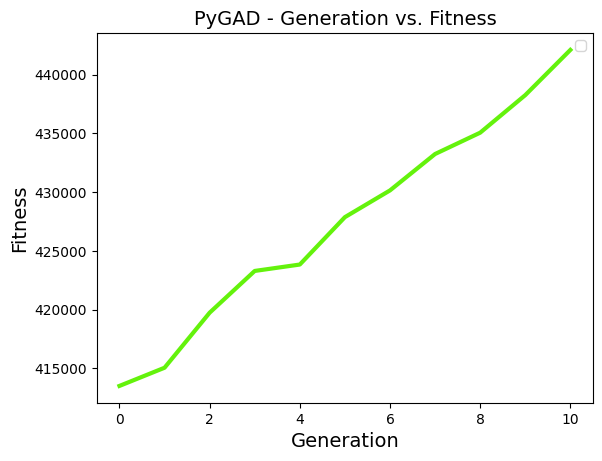

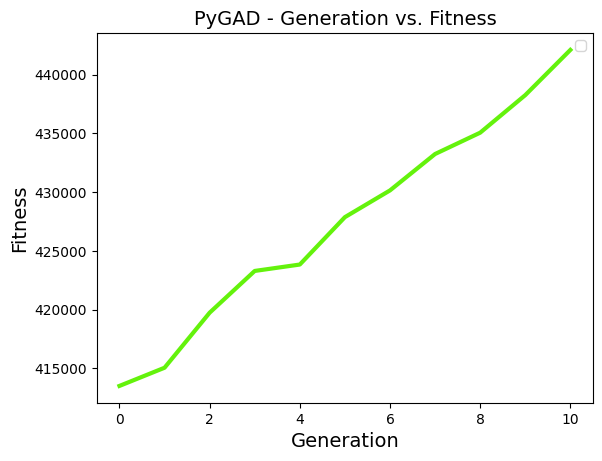

In [480]:
ga_instance.plot_fitness()

In [481]:
genetic_solution_decoded = decode_solution(ga_solution, val_pool, binary_matrix)
genetic_solution_decoded

,112Ji3ASaU21FGa4ymrjvyZrDv8LbW9tF5NLUksdLdJkjY7E,11BgR7fH8Sq6CcGcXxZrhyrBM2PUpDmhnGZpxPGvVGXEiPT,121GBc2ZK53Uoc6JovJjU7zARH8fys5efyUfHKT9vABpqajx,123VugBRFMqUEFviSYrG3ewdZ46ZmqxjmRaGY6BvakfdPVaG,124YFXA3XoRs9Epcx3aRUSk3EKYaznocqMWfrMKtGjx8TJ2W,126psKUiNKidXPNJRkD9TYcZdruX4dymU3vsQ6g9GM4YtEis,126y5f2ePBHvYorTEGUYys53tzvno6RNVwpLStJMbVukP9dJ,128xoAmYDMLixg9Dv4sQz3vJnG94Jt1s2hp37PR8CQZMMMfp,1293x8Max5nQW6J8ubgKWuEFMViQBAxb7CxfFakpApoRXYUC,12BJ7EMWbr7fGVu2DspPtGbxCCdJUfAMVbJtCm6xPEf4WGiS,...,1zugcagpF2GXENgfYE1sL5fTSscZq1s5MA4znWdRcpEF4yw,1zugcajKZ8XwjWvC5QZWcrpjfnjZZ9FfxRB9f5Hy6GdXBpZ,1zugcam9xSdgVtn4wDtFbvrRRnvW7r5mCCBDZeNEaLNiQB9,1zugcamBsgV1LNFko4B8ACy41pDWWXfjjuo3ssrREF9xVZm,1zugcanWLQRe6P9ELGtQ3QD5xxyUF7C5yC1fcbVgwsXWiVz,1zugcaomSsQ1Eu1xa8MUhcADjnY7AajAKnd1qtCqpV9mc8m,1zugcapozj3EXfPruHanbfQaPHL9ydJEmvqNnxM7KPg5g2c,1zugcarJnZ4ft2PiJoGg6DgmZjnKNBrcKTFrAzhGPCX6bJ5,1zugcauBVvcNa6tpW3j6WaGRL1Wvm9oSimK2eP3VNqNLw1V,amount
stash_address,,,,,,,,,,,,,,,,,,,,,
16Ak2D2ZApaR6sFKkawmC8ea93ASD4aB54eTMvEkDjCFZLjp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.625483e-05
14FzsWSxgWMmXwafTiGf1YdXZgEoAY7dEv2Qr9h1sCHaWFt2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.819291e-06
15LL8mQJQ7wsxrjxMyBxjphkNxciwirC6cQ5AprmmEt8KGNf,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,6.075376e-05
11888uchjZxbyc7RRstxZ8qepsskRjJhJatrxryBTdHuWfK,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,3.945346e-03
1ZQpD1knimbf4RLUyoipThPdhvEXJHud2sFDSe3cWPVN3q4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.532219e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16XMi2A7NvUuwt632GH7awa7P5MYJQrteJJ3iB13FCqeXPok,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.663159e-06
16A5SmtCw1sTDr6zXdJ9hShqUX1XbYKXG1kk8Qv2BPhTsDNC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.122758e-07
14N6uWVnUDZQfNf66HJsSFPLmJHm1p19Y44CBmVoBi9DDbRD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.437195e-11


In [482]:
compare_solutions(ref_sol, genetic_solution_decoded)

-438253.7658859139